<a href="https://colab.research.google.com/github/DGuilherme/PMTese/blob/main/SimpleTransformerConvD1AllDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [8]:
!pip install tensorflow scikit-learn

# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Compare all datasets

In [10]:
def run_predictive_maintenance(dataset_name, scaler_type='minmax', seq_length=50):
  # Load data
  column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
  train_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_{dataset_name}.txt/train_{dataset_name}.txt', delim_whitespace=True, header=None)
  test_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_{dataset_name}.txt/test_{dataset_name}.txt', delim_whitespace=True, header=None)
  rul_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_{dataset_name}.txt/RUL_{dataset_name}.txt', delim_whitespace=True, header=None)


  train_data.columns = column_names
  test_data.columns = column_names
  rul_data.columns = ['RUL']
  rul_data['id'] = range(1, len(rul_data) + 1)

  # Generate RUL for training data
  cycle_max_train = train_data.groupby('id')['cycle'].max().reset_index().rename(columns={'cycle': 'cycle_max'})
  train_data = train_data.merge(cycle_max_train, on='id')
  train_data['RUL'] = train_data['cycle_max'] - train_data['cycle']
  train_data.drop(columns=['cycle_max'], inplace=True)

  # Generate RUL for test data
  cycle_max_test = test_data.groupby('id')['cycle'].max().reset_index().rename(columns={'cycle': 'cycle_max'})
  # Merge last observed cycle and ground-truth RUL on 'id'
  test_data = test_data.merge(cycle_max_test, on='id')
  test_data = test_data.merge(rul_data, on='id')

  test_data['RUL'] = test_data['RUL'] + test_data['cycle_max'] - test_data['cycle']
  test_data.drop(columns=['cycle_max'], inplace=True)

  # Select useful features (as suggested in papers)
  useful_sensor_cols = ['setting1', 'setting2', 'setting3'] + \
      [f'sensor{i}' for i in [2, 3, 4, 7, 8, 11, 12, 13, 14, 15, 17, 20, 21]]

  train_data = train_data[['id', 'cycle'] + useful_sensor_cols + ['RUL']]
  test_data = test_data[['id', 'cycle'] + useful_sensor_cols + ['RUL']]

  # Normalize sensor values
  scaler = MinMaxScaler()
  train_data[useful_sensor_cols] = scaler.fit_transform(train_data[useful_sensor_cols])
  test_data[useful_sensor_cols] = scaler.transform(test_data[useful_sensor_cols])

  # Windowing function
  def create_sequences(data, sequence_length=30):
      sequences = []
      labels = []
      engines = data['id'].unique()
      for engine_id in engines:
          engine_data = data[data['id'] == engine_id]
          feature_data = engine_data[useful_sensor_cols].values
          label_data = engine_data['RUL'].values
          for i in range(len(feature_data) - sequence_length + 1):
              sequences.append(feature_data[i:i+sequence_length])
              labels.append(label_data[i+sequence_length-1])
      return np.array(sequences), np.array(labels)

  # Create sequences
  X_train, y_train = create_sequences(train_data)
  X_test, y_test = create_sequences(test_data)

  print("Training set:", X_train.shape, y_train.shape)
  print("Testing set:", X_test.shape, y_test.shape)

  # Transformer Encoder
  def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
      # Attention block
      attn_output = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
      attn_output = layers.Dropout(dropout)(attn_output)
      x = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)  # Add & Norm

      # Feed Forward block
      ff_output = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
      ff_output = layers.Dropout(dropout)(ff_output)
      ff_output = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ff_output)
      x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)  # Add & Norm

      return x

  # Build Model
  def build_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, mlp_units=[128], dropout=0.1, mlp_dropout=0.1, embedding_dim=64):
      inputs = keras.Input(shape=input_shape)
      x = inputs

      # https://www.tensorflow.org/tutorials/structured_data/time_series
      x = layers.Dense(embedding_dim)(inputs)

      for _ in range(num_transformer_blocks):
          x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

      x = layers.GlobalAveragePooling1D()(x)
      for units in mlp_units:
          x = layers.Dense(units, activation="relu")(x)
          x = layers.Dropout(mlp_dropout)(x)
      outputs = layers.Dense(1)(x)  # Predict RUL
      return keras.Model(inputs, outputs)

  # Compile Model
  input_shape = X_train.shape[1:]  # (window_size, num_features)
  model = build_model(input_shape)

  model.compile(
      loss="mse",
      optimizer=keras.optimizers.Adam(learning_rate=1e-4),
      metrics=["mae"]
  )

  model.summary()

  # Early stopping
  early_stopping = keras.callbacks.EarlyStopping(
  monitor="val_loss", patience=10, restore_best_weights=True)

  # Train
  history = model.fit(
      X_train, y_train,
      validation_split=0.2,
      epochs=100,
      batch_size=64,
      callbacks=[early_stopping]
  )

  # Plot loss curves
  plt.plot(history.history['loss'], label="Training Loss")
  plt.plot(history.history['val_loss'], label="Validation Loss")
  plt.legend()
  plt.show()

  # Evaluate
  #y_pred = model.predict(X_test).flatten()
  y_pred = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)

  print(f"Test RMSE: {rmse:.2f}")
  print(f"Test MAE: {mae:.2f}")

  # Optional: Plot true vs predicted RUL
  plt.figure(figsize=(10,5))
  plt.plot(y_test[:200], label="True RUL")
  plt.plot(y_pred[:200], label="Predicted RUL")
  plt.legend()
  plt.xlabel("Sample Index")
  plt.ylabel("RUL")
  plt.title("True vs Predicted RUL (First 200 Samples)")
  plt.show()

  return model, y_pred, rmse, mae


In [11]:
def compare_datasets(datasets, scaler_type='minmax', seq_length=50):
  results = []
  for dataset_name in datasets:
    model, predictions, rmse, mae = run_predictive_maintenance(dataset_name, scaler_type, seq_length)
    #rmse = np.sqrt(mse)  # Calculate RMSE
    results.append([dataset_name, rmse, mae])

  # Create a pandas DataFrame for the results
  results_df = pd.DataFrame(results, columns=['Dataset', 'RMSE', 'MAE'])
  return results_df


<ipython-input-10-cfe927f8b301>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_{dataset_name}.txt/train_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-10-cfe927f8b301>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_{dataset_name}.txt/test_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-10-cfe927f8b301>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datas

Training set: (17731, 30, 16) (17731,)
Testing set: (10196, 30, 16) (10196,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 30, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30, 64)    │      1,088 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     66,368 │ dense_8[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 30, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 30, 64)    │          0 │ dense_8[0][0],    │
│                     │                   │            │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 30, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 30, 128)   │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 30, 64)    │      8,256 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 30, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 30, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 30, 128)   │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 30, 64)    │      8,256 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 175,937 (687.25 KB)

 Trainable params: 175,937 (687.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 50s 154ms/step - loss: 10678.8926 - mae: 85.4310 - val_loss: 13450.0254 - val_mae: 92.1918
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - loss: 8729.2998 - mae: 74.7431 - val_loss: 10490.2178 - val_mae: 78.9191
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - loss: 6372.4492 - mae: 62.2080 - val_loss: 7732.3184 - val_mae: 67.1542
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - loss: 4339.4492 - mae: 51.3329 - val_loss: 5248.1265 - val_mae: 50.5571
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - loss: 2484.0020 - mae: 34.6105 - val_loss: 3711.9902 - val_mae: 41.6220
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - loss: 1730.8223 - mae: 28.0231 - val_loss: 2859.4224 - val_mae: 36.6407
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - loss: 1392.7673 - mae: 25.3768 - val_loss: 2550.4829 - val_mae: 34.6320
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - loss: 1197.5530 - mae: 23.710

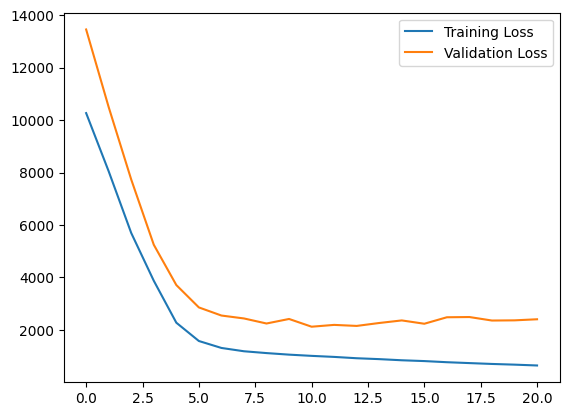

319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step
Test RMSE: 41.79
Test MAE: 30.60


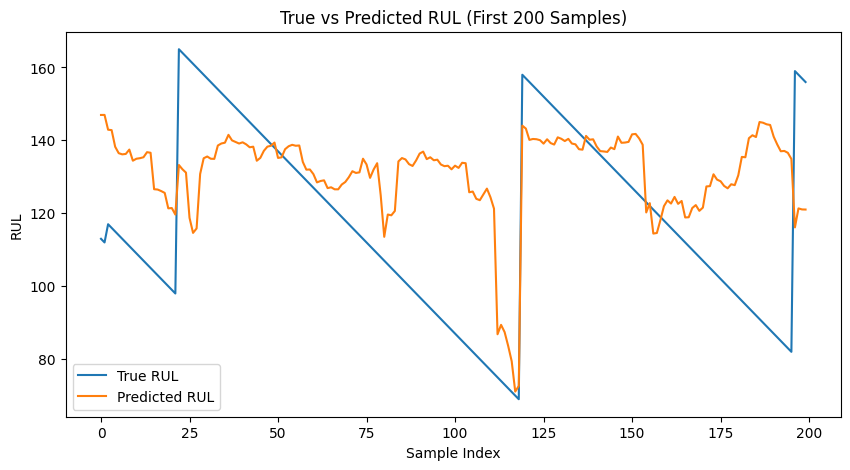

<ipython-input-10-cfe927f8b301>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_{dataset_name}.txt/train_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-10-cfe927f8b301>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_{dataset_name}.txt/test_{dataset_name}.txt', delim_whitespace=True, header=None)
<ipython-input-10-cfe927f8b301>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_data = pd.read_csv(f'/content/drive/MyDrive/Python/predictive-maintenance-main/datas

Training set: (46219, 30, 16) (46219,)
Testing set: (26505, 30, 16) (26505,)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 30, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 30, 64)    │      1,088 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     66,368 │ dense_11[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 30, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 30, 64)    │          0 │ dense_11[0][0],   │
│                     │                   │            │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 30, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 30, 128)   │          0 │ conv1d_20[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 30, 64)    │      8,256 │ dropout_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_21[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 30, 64)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 30, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 30, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 30, 128)   │          0 │ conv1d_22[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 30, 64)    │      8,256 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 175,937 (687.25 KB)

 Trainable params: 175,937 (687.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 111s 180ms/step - loss: 10641.7549 - mae: 83.2783 - val_loss: 5612.8433 - val_mae: 57.6274
Epoch 2/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 131s 161ms/step - loss: 4917.1665 - mae: 54.5306 - val_loss: 3831.1731 - val_mae: 50.5902
Epoch 3/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 140s 159ms/step - loss: 3847.7332 - mae: 50.4744 - val_loss: 3832.1492 - val_mae: 50.8846
Epoch 4/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 146s 165ms/step - loss: 3839.9729 - mae: 50.6836 - val_loss: 2678.6472 - val_mae: 38.7160
Epoch 5/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 92s 160ms/step - loss: 2381.0076 - mae: 35.8143 - val_loss: 1774.4366 - val_mae: 32.2849
Epoch 6/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 96s 166ms/step - loss: 1796.4825 - mae: 31.1445 - val_loss: 1636.5033 - val_mae: 30.4892
Epoch 7/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 140s 162ms/step - loss: 1720.6907 - mae: 30.6037 - val_loss: 1606.7676 - val_mae: 30.1808
Epoch 8/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 141s 160ms/step - loss: 1741.9364 - mae: 30

In [ ]:
# Define the list of datasets
datasets = ['FD001', 'FD002', 'FD003', 'FD004']  # Add your dataset names here

# Run the comparison
results_df = compare_datasets(datasets, scaler_type='minmax', seq_length=60)

# Display the results table
display(results_df)